In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ships-in-satellite-imagery/shipsnet.json
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20170705_180816_103e__-122.32658408124291_37.706907776737474.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20171023_190147_0f2e__-122.44931218477075_37.74813135712905.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20170917_190616_0f3c__-122.41281471377471_37.81179510079203.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20170709_181333_0e0e__-122.36013529353468_37.77093483120248.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20161116_180802_0e14__-122.49999218351591_37.88828552016498.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0__20180710_182341_1011__-122.08261432972722_37.73854704083466.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/1__20180708_182358_1032__-122.34681533273329_37.759451149806985.png
/kaggle/input/ships-in-satellite-imagery/shipsnet/shipsnet/0_

In [2]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
with open('/kaggle/input/ships-in-satellite-imagery/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [4]:
shipsnet = shipsnet[["data","labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [5]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the ship_images :1000


In [6]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')


In [7]:
x.shape

(4000, 19200)

In [8]:
x_reshaped = x.reshape([-1, 3, 80, 80])

In [9]:
x_reshaped

array([[[[ 82,  89,  91, ...,  89,  84,  83],
         [ 89,  91,  89, ..., 101,  87,  87],
         [ 91,  93,  86, ...,  83,  90,  92],
         ...,
         [ 89,  88,  92, ...,  88,  85,  89],
         [ 87,  88,  91, ...,  91,  90,  90],
         [ 88,  91,  90, ...,  88,  89,  90]],

        [[ 94,  99, 101, ..., 102,  96,  96],
         [100, 102, 101, ..., 115, 100,  99],
         [101, 104,  98, ...,  96, 102, 102],
         ...,
         [ 98,  98, 102, ...,  99,  97, 100],
         [ 99,  99, 101, ..., 101, 101, 102],
         [ 99, 101, 101, ..., 101, 102, 102]],

        [[ 80,  86,  89, ...,  86,  81,  84],
         [ 86,  88,  89, ...,  97,  84,  86],
         [ 88,  92,  85, ...,  81,  88,  89],
         ...,
         [ 87,  86,  89, ...,  86,  84,  87],
         [ 87,  86,  88, ...,  88,  88,  89],
         [ 85,  87,  87, ...,  86,  88,  89]]],


       [[[ 76,  75,  67, ...,  78,  77,  80],
         [ 71,  73,  72, ...,  79,  77,  81],
         [ 73,  70,  67, ..., 

In [10]:
x_reshaped[0].shape

(3, 80, 80)

In [11]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [12]:
import numpy as np

def add_padding(x_reshaped, target_size):
    padded_images = []
    for image in x_reshaped:
        # Get the current image size
        height, width, channels = image.shape

        # Calculate the amount of padding needed
        pad_height = max(target_size[0] - height, 0)
        pad_width = max(target_size[1] - width, 0)

        # Calculate the top, bottom, left, and right padding values
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        # Pad the image with zeros
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant')
        padded_images.append(padded_image)

    return np.array(padded_images)
# Assuming x_reshaped is an array of shape (4000, 80, 80, 3)
target_size = (224, 224, 3)
padded_images = add_padding(x_reshaped, target_size)
print(padded_images.shape)  # Output: (4000, 224, 224, 3)

(4000, 224, 224, 3)


In [13]:
x_reshaped = padded_images/255

In [14]:
x_reshaped.shape

(4000, 224, 224, 3)

In [15]:
y.shape

(4000,)

In [16]:
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [17]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [18]:
x_reshaped[0][0][0] # Normalized RGB values of the firs pixel of the first image in the dataset.

array([0., 0., 0.])

In [19]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, 
                                                  test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)
print("x_train_1 shape",x_train_1.shape)
print("x_val shape",x_val.shape)
print("y_train_1 shape",y_train_1.shape)

x_train shape (2400, 224, 224, 3)
x_test shape (800, 224, 224, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 224, 224, 3)
y_test shape (800, 2)
x_train_1 shape (3200, 224, 224, 3)
x_val shape (800, 224, 224, 3)
y_train_1 shape (3200, 2)


In [20]:
x_test.shape

(800, 224, 224, 3)

In [21]:
x_train.shape

(2400, 224, 224, 3)

**MobileNet**

In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

In [23]:
# Load the MobileNetV2 model pretrained on ImageNet dataset without the fully connected layers
# Load the MobileNetV2 model pretrained on ImageNet dataset without the fully connected layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [25]:
n_classes=2
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Unfreeze the last 20 layers
    layer.trainable = False
    
# Create the model by adding custom Dense layers on top of the base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Global Average Pooling to reduce the spatial dimensions
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Adding Dropout layer with 50% dropout rate
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 64)                81984     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 2,340,098
Trainable params: 1,288,194
No

In [37]:
# Custom Affine Transformation Function
def apply_affine_transform(image):
    # Define the affine transformation parameters
    shear_range = 20
    translation_range = 0.2
    zoom_range = [0.8, 1.2]
    rotation_range = 20

    # Apply the affine transformations
    rows, cols, _ = image.shape
    shear = np.random.randint(-shear_range, shear_range)
    translation_x = np.random.randint(-translation_range * cols, translation_range * cols)
    translation_y = np.random.randint(-translation_range * rows, translation_range * rows)
    zoom = np.random.uniform(zoom_range[0], zoom_range[1])
    rotation = np.random.randint(-rotation_range, rotation_range)

    matrix = cv2.getRotationMatrix2D((cols // 2, rows // 2), rotation, zoom)
    matrix[:, 2] += (translation_x, translation_y)

    # Apply shear separately for x and y directions
    shear_matrix = np.array([[1, abs(np.tan(np.deg2rad(shear))), 0],
                             [0, 1, 0]])
    if shear > 0:
        image = cv2.warpAffine(image, shear_matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)
    else:
        image = cv2.warpAffine(image, shear_matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)

    return cv2.warpAffine(image, matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)

In [38]:
# Data Augmentation with Affine Transformations
aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=apply_affine_transform)

In [41]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate schedule function

def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr / 100

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

BS = 20
EPOCHS = 15
# Fit the model using data augmentation
steps_per_epoch = len(x_train) // BS  # Use integer division

history = model.fit(aug.flow(x_train, y_train, batch_size=BS),
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/15
120/120 [==============================] - 95s 794ms/step - loss: 0.0875 - accuracy: 0.9733 - val_loss: 0.0986 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 2/15
120/120 [==============================] - 91s 754ms/step - loss: 0.0805 - accuracy: 0.9775 - val_loss: 0.0946 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 3/15
120/120 [==============================] - 92s 770ms/step - loss: 0.0991 - accuracy: 0.9733 - val_loss: 0.1730 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 4/15
120/120 [==============================] - 92s 768ms/step - loss: 0.0804 - accuracy: 0.9762 - val_loss: 0.8307 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 5/15
120/120 [==============================] - 96s 797ms/step - loss: 0.0663 - accuracy: 0.9808 - val_loss: 0.1469 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 6/15
120/120 [==============================] - 96s 804ms/step - loss: 0.0870 - accuracy: 0.9771 - val_loss: 0.1297 - val_accuracy: 0.9850 - lr: 1.0000e-05
Epoch 7/15
120/120 [============================

In [42]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 18s 713ms/step - loss: 0.0473 - accuracy: 0.9887


[0.04730144888162613, 0.9887499809265137]

25/25 [==============================] - 20s 751ms/step

Test Accuracy Score :  0.98875 



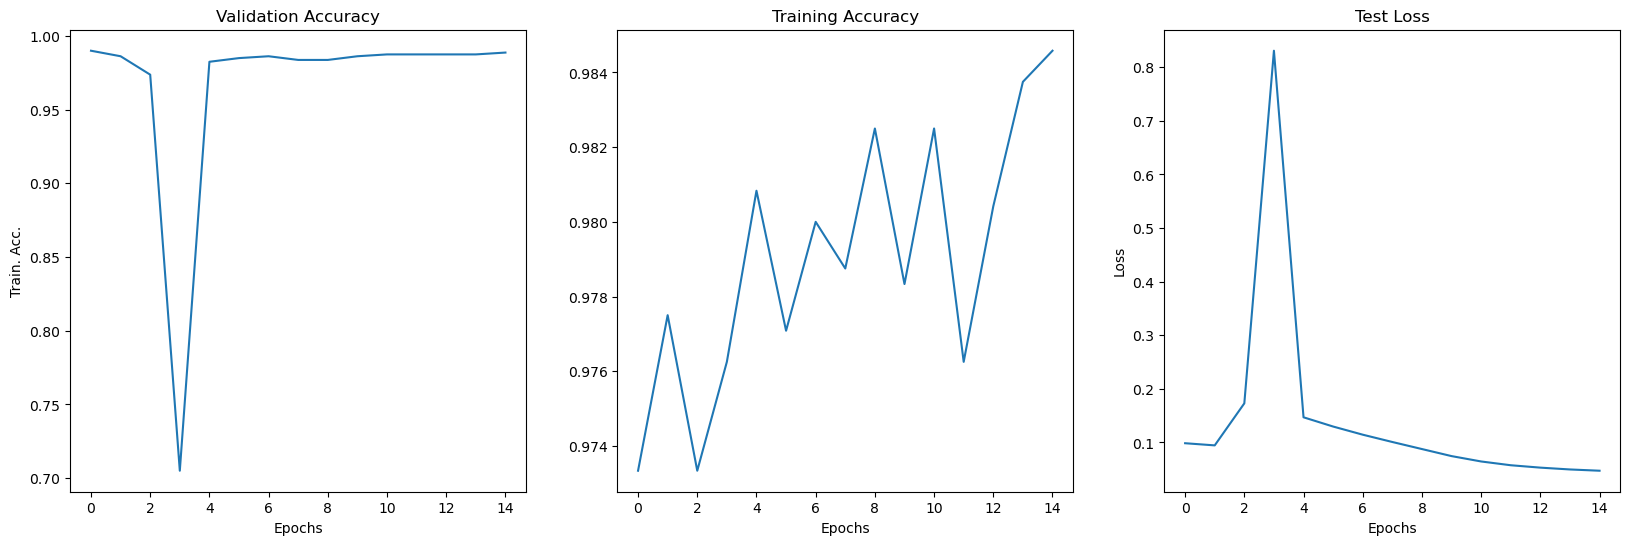

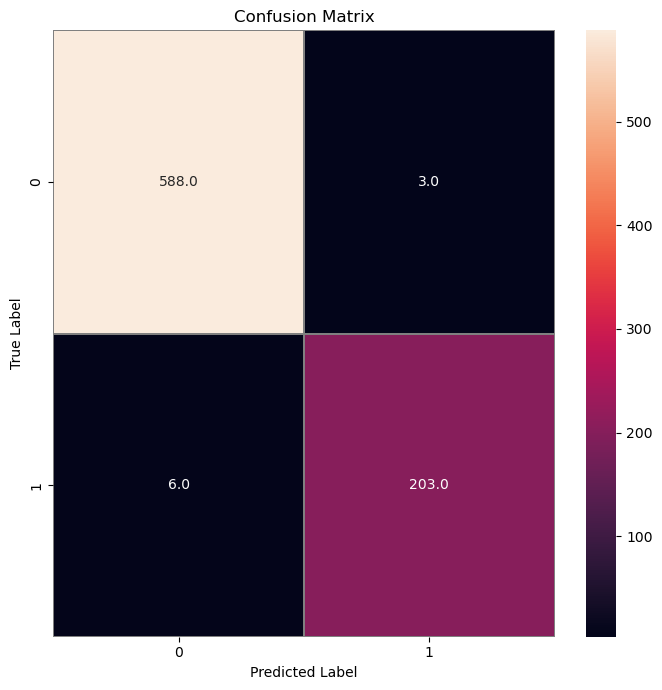

In [43]:
from sklearn import metrics
import seaborn as sns
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# Compute the confusion matrix

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

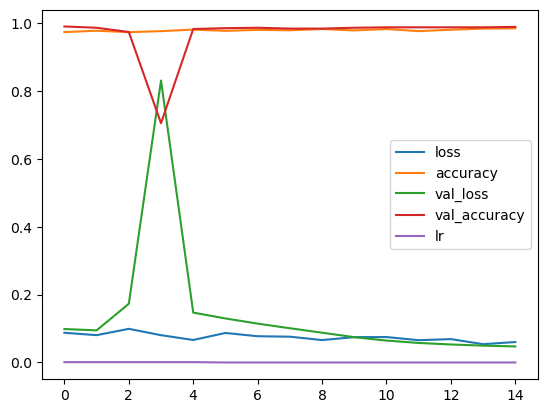

In [44]:
pd.DataFrame(history.history).plot();

In [45]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

25/25 [==============================] - 19s 765ms/step


Not A Ship    0.000875
Ship          0.999125
dtype: float32

In [46]:
predicted_data = pd.DataFrame(prediction, columns=["Not A Ship", "Ship"])
predicted_data.head()

,Not A Ship,Ship
0,0.000875,9.991248e-01
1,0.999999,8.628655e-07
2,0.000312,9.996879e-01
3,0.999998,1.799054e-06
4,1.000000,5.921438e-08


In [47]:
y_test_data = pd.DataFrame(y_test, columns=["Not A Ship", "Ship"])
y_test_data.head()

,Not A Ship,Ship
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,1.0,0.0


In [48]:
predicted_data['There is a Ship'] = y_test[:, 1]
predicted_data.head()

,Not A Ship,Ship,There is a Ship
0,0.000875,9.991248e-01,1.0
1,0.999999,8.628655e-07,0.0
2,0.000312,9.996879e-01,1.0
3,0.999998,1.799054e-06,0.0
4,1.000000,5.921438e-08,0.0


In [49]:
predicted_data["Difference"] = predicted_data["Ship"] - predicted_data["There is a Ship"]
predicted_data

,Not A Ship,Ship,There is a Ship,Difference
0,0.000875,9.991248e-01,1.0,-8.752346e-04
1,0.999999,8.628655e-07,0.0,8.628655e-07
2,0.000312,9.996879e-01,1.0,-3.120899e-04
3,0.999998,1.799054e-06,0.0,1.799054e-06
4,1.000000,5.921438e-08,0.0,5.921438e-08
...,...,...,...,...
795,0.970601,2.939886e-02,0.0,2.939886e-02
796,0.001794,9.982063e-01,1.0,-1.793742e-03
797,0.999952,4.753029e-05,0.0,4.753029e-05
798,1.000000,1.064112e-08,0.0,1.064112e-08


In [50]:
predicted_data.sort_values('Difference', ascending=False).head(10)

,Not A Ship,Ship,There is a Ship,Difference
528,0.003850,0.996150,0.0,0.996150
717,0.142872,0.857128,0.0,0.857128
536,0.166102,0.833897,0.0,0.833897
191,0.511408,0.488592,0.0,0.488592
339,0.635377,0.364623,0.0,0.364623
493,0.659080,0.340920,0.0,0.340920
66,0.751161,0.248839,0.0,0.248839
185,0.777741,0.222259,0.0,0.222259
737,0.832679,0.167321,0.0,0.167321
266,0.954896,0.045104,0.0,0.045104


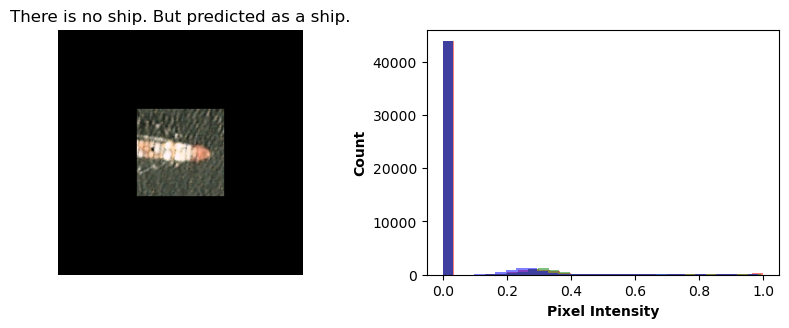

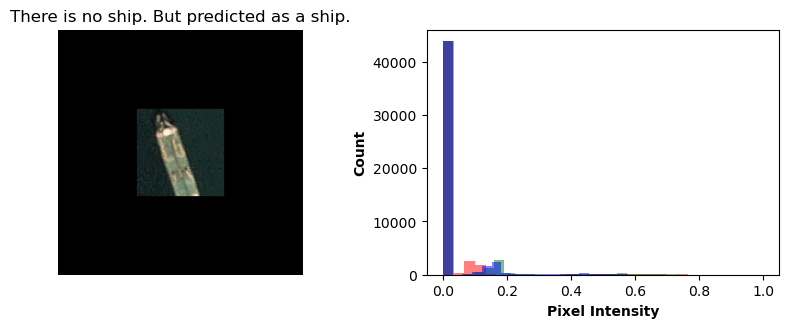

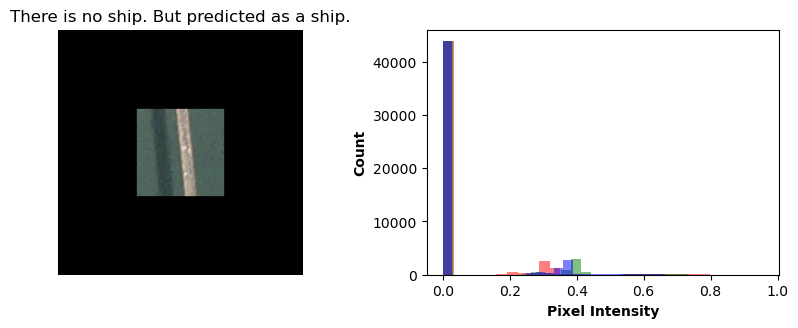

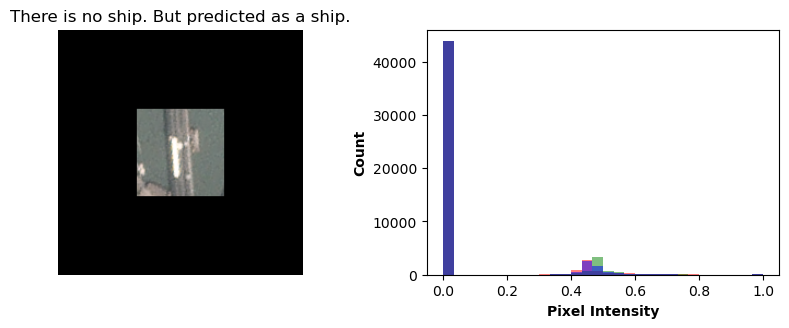

In [51]:
indexes = predicted_data.sort_values('Difference', ascending = False).head(4).index.to_list()

def plotHistogram(image_index):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(x_test[image_index])
    plt.axis('off')
    plt.title('There is no ship. But predicted as a ship.')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(x_test[image_index][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(x_test[image_index][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    
for i in indexes:
    plotHistogram(i)

In [54]:
import pickle

# Assuming you have already trained the model and stored it in the 'model' variable
# Save the model to a file using pickle
with open('/kaggle/working/mobilenet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# To load the model later, you can use the following:
# with open('/kaggle/working/mobilenet_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)
